 ### Time Series Forecasting with XGBoost - Use python and machine learning to predict stock market prices

In [601]:
try:
    import xgboost as xgb
except:
    !pip install xgboost

In [602]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error  ###mean squared error give more penalty for predictions that are   way off rather than alittle off
from sklearn.model_selection import cross_val_score
                                              
plt.style.use("fivethirtyeight")

In [603]:
dateparser = lambda x:dt.datetime.strptime(x,"%Y-%m-%d %I-%p")
df = pd.read_csv("csv_data/ETH-1h.csv",parse_dates=["Date"],date_parser=dateparser,index_col="Date")
df

,Symbol,Open,High,Low,Close,Volume
Date,,,,,,
2020-03-13 20:00:00,ETHUSD,129.94,131.82,126.87,128.71,1940673.93
2020-03-13 19:00:00,ETHUSD,119.51,132.02,117.10,129.94,7579741.09
2020-03-13 18:00:00,ETHUSD,124.47,124.85,115.50,119.51,4898735.81
2020-03-13 17:00:00,ETHUSD,124.08,127.42,121.63,124.47,2753450.92
2020-03-13 16:00:00,ETHUSD,124.85,129.51,120.17,124.08,4461424.71
...,...,...,...,...,...,...
2017-07-01 15:00:00,ETHUSD,265.74,272.74,265.00,272.57,1500282.55
2017-07-01 14:00:00,ETHUSD,268.79,269.90,265.00,265.74,1702536.85
2017-07-01 13:00:00,ETHUSD,274.83,274.93,265.00,268.79,3010787.99


In [604]:
# df["Date"] = pd.to_datetime(df["Date"],format="%Y-%m-%d %I-%p")
# df

In [605]:
df = df.loc[:,["Close"]]
df

,Close
Date,
2020-03-13 20:00:00,128.71
2020-03-13 19:00:00,129.94
2020-03-13 18:00:00,119.51
2020-03-13 17:00:00,124.47
2020-03-13 16:00:00,124.08
...,...
2017-07-01 15:00:00,272.57
2017-07-01 14:00:00,265.74
2017-07-01 13:00:00,268.79


In [606]:
train = df.loc[df.index < "2019-9-1"]
test = df.loc[df.index >= "2019-9-1"]
len(train),len(test)

(18997, 4677)

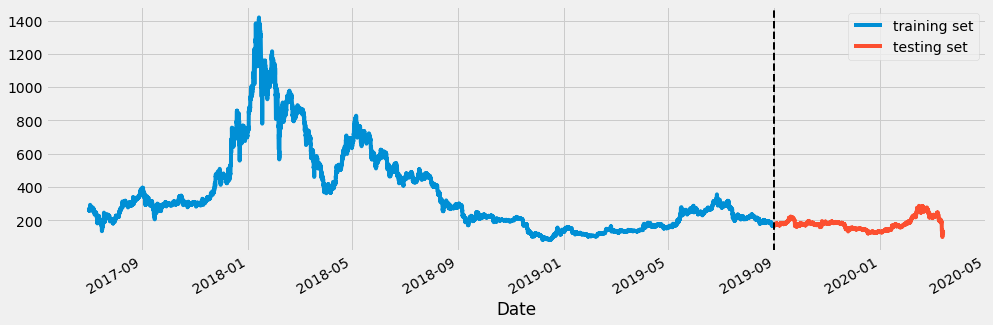

In [607]:
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax,label="training set")
test.plot(ax=ax, label="testing set")
ax.axvline("2019-9-1", color="black",linewidth=2,linestyle="--")
ax.legend(["training set","testing set"])
plt.show()

In [608]:
df.loc[(df.index > "2018-6-10") & (df.index < "2018-6-17")]

,Close
Date,
2018-06-16 23:00:00,497.31
2018-06-16 22:00:00,499.99
2018-06-16 21:00:00,500.75
2018-06-16 20:00:00,498.90
2018-06-16 19:00:00,497.74
...,...
2018-06-10 05:00:00,572.89
2018-06-10 04:00:00,571.86
2018-06-10 03:00:00,570.24


<AxesSubplot:title={'center':'week of data'}, xlabel='Date'>

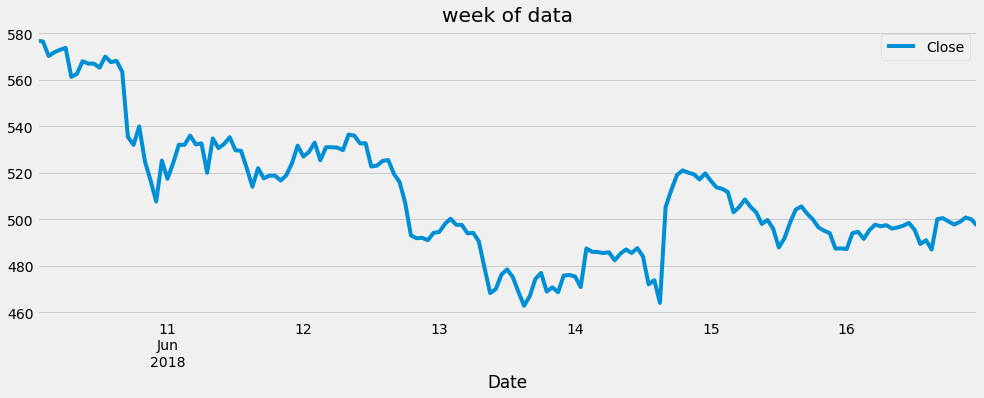

In [609]:
df.loc[(df.index > "2018-6-10") & (df.index < "2018-6-17")].plot(figsize=(15,5),title="week of data")


In [610]:
def create_features(df):
    """
    create time series features based on time series index
    """
    df = df.copy()
    df["hour"] = df.index.hour
    df["day of week"] = df.index.day_of_week
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["day of year"] = df.index.day_of_year

    return df

df = create_features(df)

In [611]:
df["Close"].mean()


324.92660133479814

Text(0.5, 1.0, 'stock market closed prices')

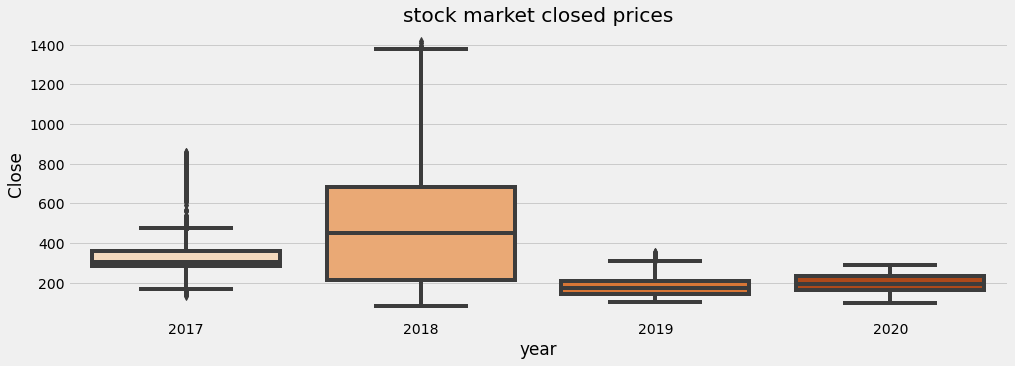

In [612]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df, x="year", y="Close", palette="Oranges")
ax.set_title("stock market closed prices")

In [613]:
train = create_features(train)
test = create_features(test)
train

,Close,hour,day of week,quarter,month,year,day of year
Date,,,,,,,
2019-08-31 23:00:00,171.93,23,5,3,8,2019,243
2019-08-31 22:00:00,172.81,22,5,3,8,2019,243
2019-08-31 21:00:00,173.80,21,5,3,8,2019,243
2019-08-31 20:00:00,166.56,20,5,3,8,2019,243
2019-08-31 19:00:00,167.63,19,5,3,8,2019,243
...,...,...,...,...,...,...,...
2017-07-01 15:00:00,272.57,15,5,3,7,2017,182
2017-07-01 14:00:00,265.74,14,5,3,7,2017,182
2017-07-01 13:00:00,268.79,13,5,3,7,2017,182


In [614]:
features = df.drop(columns=["Close"],axis=1).columns
target = "Close"
features,target

(Index(['hour', 'day of week', 'quarter', 'month', 'year', 'day of year'], dtype='object'),
 'Close')

In [615]:
X_train = train[features]
X_test = test[features]
y_train = train[target]
y_test = test[target]
X_train

,hour,day of week,quarter,month,year,day of year
Date,,,,,,
2019-08-31 23:00:00,23,5,3,8,2019,243
2019-08-31 22:00:00,22,5,3,8,2019,243
2019-08-31 21:00:00,21,5,3,8,2019,243
2019-08-31 20:00:00,20,5,3,8,2019,243
2019-08-31 19:00:00,19,5,3,8,2019,243
...,...,...,...,...,...,...
2017-07-01 15:00:00,15,5,3,7,2017,182
2017-07-01 14:00:00,14,5,3,7,2017,182
2017-07-01 13:00:00,13,5,3,7,2017,182


In [616]:
# reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds=50 )  #stop at 50 if model is not improving
# reg.fit(X_train,y_train,
#         eval_set = [(X_train, y_train),(X_test, y_test)],
#        verbose=True)

"""result: for validation on the right model stop learning at 5 epochs while training on the left is still
learning which means overfitting,note: rmse is root mean squared error function"""

'result: for validation on the right model stop learning at 5 epochs while training on the left is still\nlearning which means overfitting,note: rmse is root mean squared error function'

In [617]:
y_train.shape

(18997,)

In [618]:
# from sklearn.linear_model import LinearRegression
# regressor = LinearRegression()

# cross_val_score(regressor, X_train, y_train, cv=5, scoring='accuracy').mean()

In [619]:
##we lower learning rare to avoid overfitting
reg = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds=50,
                      learning_rate=1e-3)  #stop at 50 if model is not improving
reg.fit(X_train,y_train,
        eval_set = [(X_train, y_train),(X_test, y_test)],
       verbose=100)

[0]	validation_0-rmse:250.12215	validation_1-rmse:184.94449
[100]	validation_0-rmse:226.86036	validation_1-rmse:166.94377
[200]	validation_0-rmse:205.83740	validation_1-rmse:150.57268
[300]	validation_0-rmse:186.79759	validation_1-rmse:135.40840
[400]	validation_0-rmse:169.58342	validation_1-rmse:121.70406
[500]	validation_0-rmse:153.93893	validation_1-rmse:109.57031
[600]	validation_0-rmse:139.78249	validation_1-rmse:98.82832
[700]	validation_0-rmse:127.01631	validation_1-rmse:89.38541
[800]	validation_0-rmse:115.48746	validation_1-rmse:81.15149
[900]	validation_0-rmse:105.08025	validation_1-rmse:74.03649
[999]	validation_0-rmse:95.78678	validation_1-rmse:68.01942


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## feature importance

In [620]:
reg.feature_importances_

array([1.3946898e-05, 1.2593318e-03, 2.8334393e-03, 2.7061801e-02,
       8.2439113e-01, 1.4444026e-01], dtype=float32)

In [621]:
reg.feature_names_in_

array(['hour', 'day of week', 'quarter', 'month', 'year', 'day of year'],
      dtype='<U11')

In [622]:
fi = pd.DataFrame(data=reg.feature_importances_,
            columns=["importance"],
            index=reg.feature_names_in_)
fi

,importance
hour,0.000014
day of week,0.001259
quarter,0.002833
month,0.027062
year,0.824391
day of year,0.144440


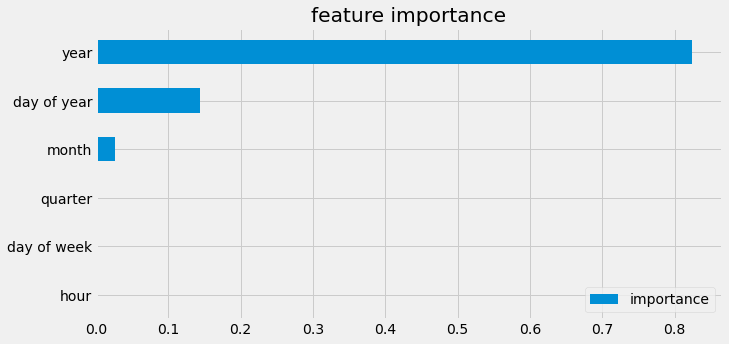

In [623]:
fi.sort_values(by=["importance"]).plot(kind="barh", title="feature importance",figsize=(10,5))
plt.legend(loc="lower right")

In [624]:
test["predictions"] = reg.predict(X_test)
test

,Close,hour,day of week,quarter,month,year,day of year,predictions
Date,,,,,,,,
2020-03-13 20:00:00,128.71,20,4,1,3,2020,73,219.19458
2020-03-13 19:00:00,129.94,19,4,1,3,2020,73,219.19458
2020-03-13 18:00:00,119.51,18,4,1,3,2020,73,219.19458
2020-03-13 17:00:00,124.47,17,4,1,3,2020,73,219.19458
2020-03-13 16:00:00,124.08,16,4,1,3,2020,73,219.19458
...,...,...,...,...,...,...,...,...
2019-09-01 04:00:00,172.77,4,6,3,9,2019,244,241.90007
2019-09-01 03:00:00,172.75,3,6,3,9,2019,244,241.90007
2019-09-01 02:00:00,172.84,2,6,3,9,2019,244,241.90007


In [625]:
df

,Close,hour,day of week,quarter,month,year,day of year
Date,,,,,,,
2020-03-13 20:00:00,128.71,20,4,1,3,2020,73
2020-03-13 19:00:00,129.94,19,4,1,3,2020,73
2020-03-13 18:00:00,119.51,18,4,1,3,2020,73
2020-03-13 17:00:00,124.47,17,4,1,3,2020,73
2020-03-13 16:00:00,124.08,16,4,1,3,2020,73
...,...,...,...,...,...,...,...
2017-07-01 15:00:00,272.57,15,5,3,7,2017,182
2017-07-01 14:00:00,265.74,14,5,3,7,2017,182
2017-07-01 13:00:00,268.79,13,5,3,7,2017,182


In [626]:
# df = pd.concat([df,test["predictions"]],axis=1)
# df

In [627]:
##similar to above
df = df.merge(test["predictions"], how="left", left_index=True,right_index=True)
df

,Close,hour,day of week,quarter,month,year,day of year,predictions
Date,,,,,,,,
2020-03-13 20:00:00,128.71,20,4,1,3,2020,73,219.19458
2020-03-13 19:00:00,129.94,19,4,1,3,2020,73,219.19458
2020-03-13 18:00:00,119.51,18,4,1,3,2020,73,219.19458
2020-03-13 17:00:00,124.47,17,4,1,3,2020,73,219.19458
2020-03-13 16:00:00,124.08,16,4,1,3,2020,73,219.19458
...,...,...,...,...,...,...,...,...
2017-07-01 15:00:00,272.57,15,5,3,7,2017,182,NaN
2017-07-01 14:00:00,265.74,14,5,3,7,2017,182,NaN
2017-07-01 13:00:00,268.79,13,5,3,7,2017,182,NaN


In [628]:
df.isnull().sum()

Close              0
hour               0
day of week        0
quarter            0
month              0
year               0
day of year        0
predictions    18997
dtype: int64

Text(0.5, 1.0, 'truth vs prediction')

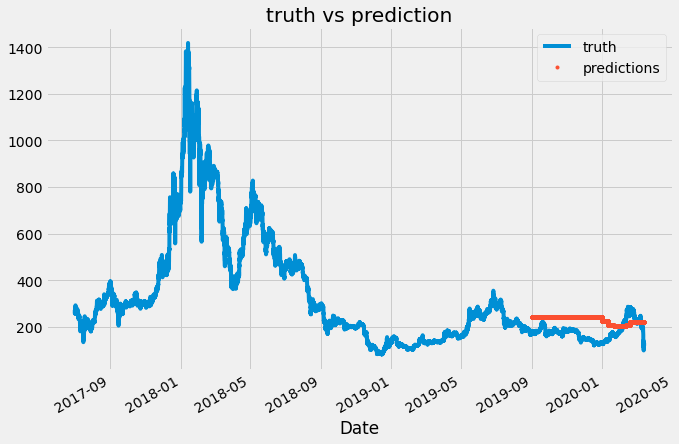

In [629]:
ax = df["Close"].plot(label="truth",figsize=(10,7))
df["predictions"].plot(ax=ax,label="predictions",style=".")
plt.legend()
ax.set_title("truth vs prediction")

In [630]:
filt = (df.index < "2020-2-10") & (df.index >= "2020-2-3")
df.loc[filt, ["predictions"]]

,predictions
Date,
2020-02-09 23:00:00,205.586624
2020-02-09 22:00:00,205.586624
2020-02-09 21:00:00,205.586624
2020-02-09 20:00:00,205.586624
2020-02-09 19:00:00,205.586624
...,...
2020-02-03 04:00:00,204.239594
2020-02-03 03:00:00,204.239594
2020-02-03 02:00:00,204.239594


## predictions in 10days range

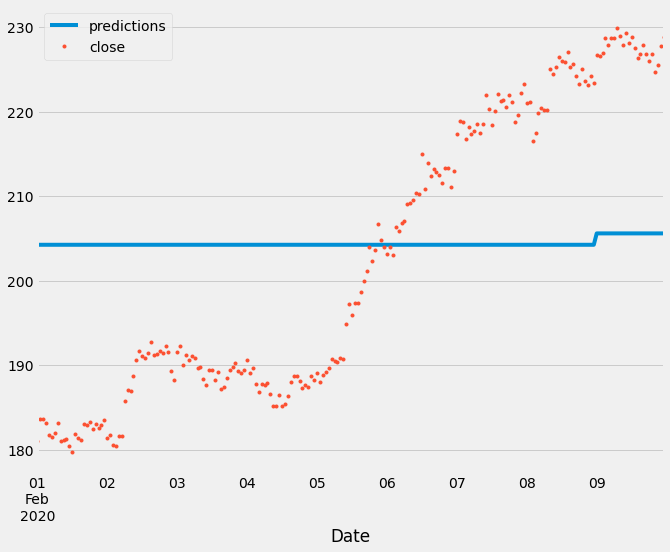

In [631]:
filt = (df.index < "2020-2-10") & (df.index >= "2020-2-1")
ax = df.loc[filt, "predictions"].plot(figsize=(10,8), label="predictions")
df.loc[filt, "Close"].plot(ax=ax,style=".", label="close")
plt.legend()

In [632]:
score = np.sqrt(mean_squared_error(test["Close"], test["predictions"]))
print(f"RMSE score: {score:.4f}")

RMSE score: 68.0194


## look at worst and best dates for predicitons

In [633]:
test["error"] = np.abs(test[target]-test["predictions"])
test["date"] = test.index.date

In [634]:
test

,Close,hour,day of week,quarter,month,year,day of year,predictions,error,date
Date,,,,,,,,,,
2020-03-13 20:00:00,128.71,20,4,1,3,2020,73,219.19458,90.48458,2020-03-13
2020-03-13 19:00:00,129.94,19,4,1,3,2020,73,219.19458,89.25458,2020-03-13
2020-03-13 18:00:00,119.51,18,4,1,3,2020,73,219.19458,99.68458,2020-03-13
2020-03-13 17:00:00,124.47,17,4,1,3,2020,73,219.19458,94.72458,2020-03-13
2020-03-13 16:00:00,124.08,16,4,1,3,2020,73,219.19458,95.11458,2020-03-13
...,...,...,...,...,...,...,...,...,...,...
2019-09-01 04:00:00,172.77,4,6,3,9,2019,244,241.90007,69.13007,2019-09-01
2019-09-01 03:00:00,172.75,3,6,3,9,2019,244,241.90007,69.15007,2019-09-01
2019-09-01 02:00:00,172.84,2,6,3,9,2019,244,241.90007,69.06007,2019-09-01


In [635]:
test.groupby("date")["error"].mean().sort_values(ascending=False)

date
2019-12-27    116.790904
2019-12-25    116.762987
2019-12-18    116.541737
2019-12-26    116.189654
2019-12-21    114.633404
                 ...    
2020-03-02      6.582398
2020-02-28      6.205802
2020-02-06      5.872388
2020-03-04      5.195420
2020-03-01      2.695487
Name: error, Length: 195, dtype: float64

## next steps
- more robust cross validation
- add more features